**Tabular data science project - Part 2**

Tamar Michelson   323805861

Devora Siminovsky 213506272

<font color="blue">The first section is the model and error analysis from part 1. In processing the data we added another option for filling missing values. In all these sections we added analysis comments oriented to the model improvements of part 2 (part 2 section). All these will be in blue.</font>


## Explanation of the data set


The used and refurbished device market has experienced significant growth over the past decade, offering cost-effective alternatives for both consumers and businesses seeking to save money when purchasing devices. Extending the lifespan of these devices through second-hand trade not only provides financial benefits but also plays a crucial role in reducing their environmental impact, contributing to recycling efforts, and minimizing waste.

We chose to focus on this dataset to perform an analysis and develop a predictive model for estimating the number of days a device was in use. This decision stems from our interest in understanding the usage patterns and lifecycle of refurbished devices. By predicting their usage duration, we aim to gain valuable insights into device longevity, which can inform both consumer decisions and business strategies in the refurbished market. Furthermore, such predictions can help promote sustainable practices by encouraging more efficient utilization and reuse of devices, ultimately contributing to a greener, more circular economy.


### Project goal

In Part A, we aimed to build a predictive model to estimate the number of days a second-hand phone was used.

In Part B, our goal is to enhance the performance of the initial model. By identifying its weaknesses and applying various improvement techniques learned throughout the course, we strive to refine its predictive accuracy and robustness.

##Part 1 (model from part 1, analysis for part 2 was added also in this section)

###Imports and download

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [ ]:
df = pd.read_csv("./data/used_device_data.csv")

###Preprocessing the data

In [3]:
# Convert "yes" and "no" in specific columns to binary values (1 and 0)
columns_with_yes_no = ['4g', '5g']
df[columns_with_yes_no] = df[columns_with_yes_no].replace({"yes": 1, "no": 0})

# Infer and optimize data types for object columns
df = df.infer_objects(copy=False)

<ipython-input-3-acf7e318d4ac>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_with_yes_no] = df[columns_with_yes_no].replace({"yes": 1, "no": 0})


In [4]:
df.head()

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,1,0,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,1,1,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,1,1,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,1,1,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,1,0,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


In [5]:
df = df.drop(columns=["release_year"])

<font color="blue">For the next stages, we here process categorial data and missing values in 2 ways. </font>

<font color="blue">In df_one_hot we processed the categorial data using one hot encodeing as we did in part 1. Then all the data is numeric and it is possible to fill missing values with the median.</font>

<font color="blue">We also have df_embedding in which later we processed the categorial data with learned embeddings. Since not all data is numeric, the missing values in the categorial columns we filled with the most frequent value.</font>

In [6]:
# Process of the data with one-hot encoding
# Convert categorical variables into dummy/one-hot-encoded variables
df_one_hot = pd.get_dummies(df)
# Convert boolean columns to binary values (1 and 0)
df_one_hot = df_one_hot.apply(
    lambda col: col.astype(int) if col.dtype == bool else col
)
# Count rows with NaN values before processing
rows_with_nan_count = df_one_hot.isna().any(axis=1).sum()
print(f"Number of rows with NaN values: {rows_with_nan_count}")
# Fill missing values
df_one_hot.fillna(df_one_hot.median(), inplace=True)
# Count rows with NaN values after processing
rows_with_nan_count_after_processing = df_one_hot.isna().any(axis=1).sum()
print(f"Number of rows with NaN values after processing: {rows_with_nan_count_after_processing}")

Number of rows with NaN values: 201
Number of rows with NaN values after processing: 0


In [7]:
# Create a copy of the DataFrame
df_embedding = df.copy()

# Count rows with NaN values before processing
rows_with_nan_count = df_embedding.isna().any(axis=1).sum()
print(f"Number of rows with NaN values: {rows_with_nan_count}")

# Loop through columns to fill NaN values based on column type
for column in df_embedding.columns:
    if df_embedding[column].dtype in ['float64', 'int64']:  # Numeric columns
        median_value = df_embedding[column].median()
        df_embedding[column] = df_embedding[column].fillna(median_value)
    else:  # Categorical columns
        mode_value = df_embedding[column].mode()[0]
        df_embedding[column] = df_embedding[column].fillna(mode_value)

# Count rows with NaN values after processing
rows_with_nan_count_after_processing = df_embedding.isna().any(axis=1).sum()
print(f"Number of rows with NaN values after processing: {rows_with_nan_count_after_processing}")


Number of rows with NaN values: 201
Number of rows with NaN values after processing: 0


###Basic Model Pipeline



In this section, we showd again the results from part 1 to compare to.

We performed a train-test split on the dataset to prepare it for model evaluation, with 80% of the data used for training and 20% for testing. We then trained the model: XGBoost Regressor. the model was evaluated using the mean squared error (MSE), mean absolute error (MAE), and R² score, which were calculated for the predictions on the test set. The results were displayed in a table format.









In [18]:
# Train-test split

X = df_one_hot.drop(columns=["days_used"])
y = df_one_hot["days_used"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_basic = X_test.copy()
y_test_basic = y_test.copy()
# XGBoost Model
xgb_basic = XGBRegressor()
xgb_basic.fit(X_train, y_train)
y_pred_xgb_basic = xgb_basic.predict(X_test)


In [19]:
# Results

mse_xgb = mean_squared_error(y_test, y_pred_xgb_basic)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb_basic)
r2_xgb = r2_score(y_test, y_pred_xgb_basic)



In [20]:
from tabulate import tabulate

# Model evaluation results
results = [
    ["XGBoost", rmse_xgb, mae_xgb, r2_xgb]
]

# Define headers
headers = ["Model", "RMSE", "MAE", "R²"]

# Print the results in a nicely formatted table
print("Model Evaluation Results:")
print(tabulate(results, headers=headers, floatfmt=".4f", tablefmt="pretty"))


Model Evaluation Results:
+---------+--------------------+------------------+-------------------+
|  Model  |        RMSE        |       MAE        |        R²         |
+---------+--------------------+------------------+-------------------+
| XGBoost | 167.91102787265046 | 137.502197265625 | 0.558043360710144 |
+---------+--------------------+------------------+-------------------+


###Error Analysis

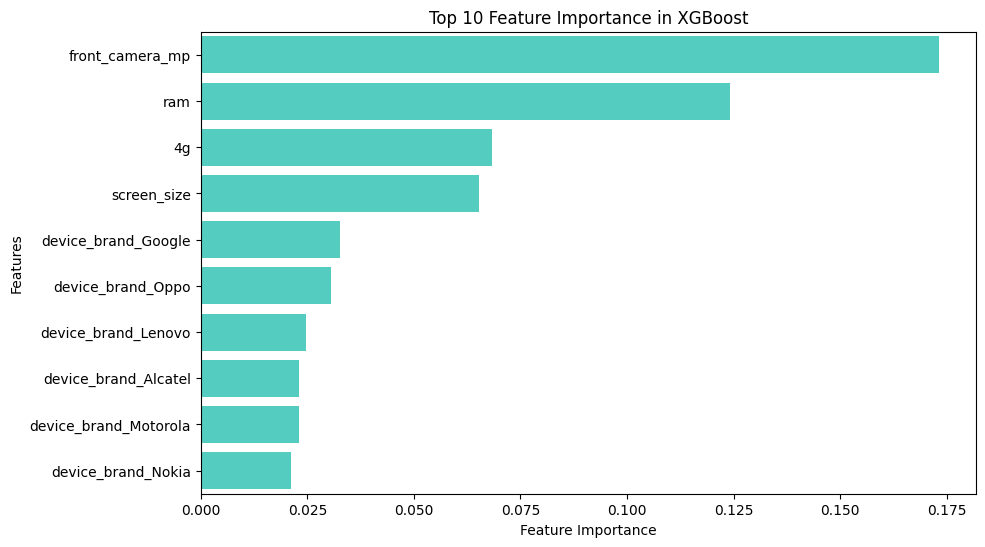

In [21]:

# Feature importance from XGBoost
feats = pd.DataFrame(index=X.columns, data=xgb_basic.feature_importances_, columns=["Feature Importance"])
XGB_feature_imp = feats.sort_values("Feature Importance", ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
sns.barplot(y=XGB_feature_imp.head(10).index, x=XGB_feature_imp.head(10)["Feature Importance"], orient="h",color='turquoise')
plt.title("Top 10 Feature Importance in XGBoost")
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()


<font color="blue">As can be seen in the feature importance plot, a lot of the top 10 features are device brand, that became many features when we used one hot encoding.
That is why we thought to use a learnd embedding instead of one-hot encoding, in order to get better results.

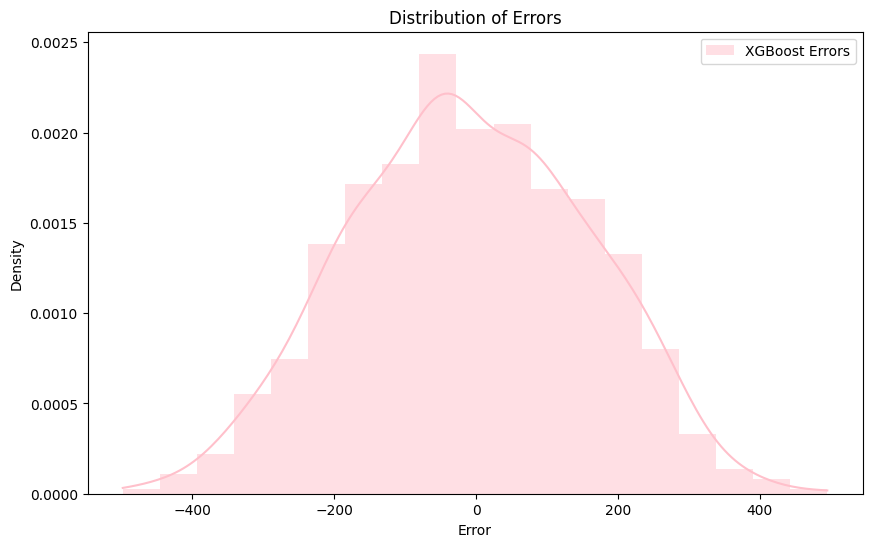

In [22]:

errors_xgb = y_test - y_pred_xgb_basic

# Plot error distributions for both models
plt.figure(figsize=(10, 6))
sns.histplot(errors_xgb, color='pink', label='XGBoost Errors', kde=True, stat="density", linewidth=0)
plt.title("Distribution of Errors")
plt.xlabel('Error')
plt.ylabel('Density')
plt.legend()
plt.show()


The position of the error distribution relative to zero determines if the model is overestimating or underestimating.

The distribution is approximately centered around zero, which means the model is balanced in terms of overestimation and underestimation.

<font color="blue">Many errors are close to 0 error which means they have a small eroor.

<font color="blue">Even so, we care more about the larger errors, even if they occur less frequently, as they often have a more significant impact. And also because when predicting days used of device a small error is not so meaningful as a large error.

<font color="blue">Unlike Mean Absolute Error (MAE), which treats all errors equally, Root Mean Squared Error (RMSE) penalizes larger errors more heavily due to its squared error term. So in our case we will calculate both MAE and RMSE and use them as evaluation metrics, but try to minimize RMSE.

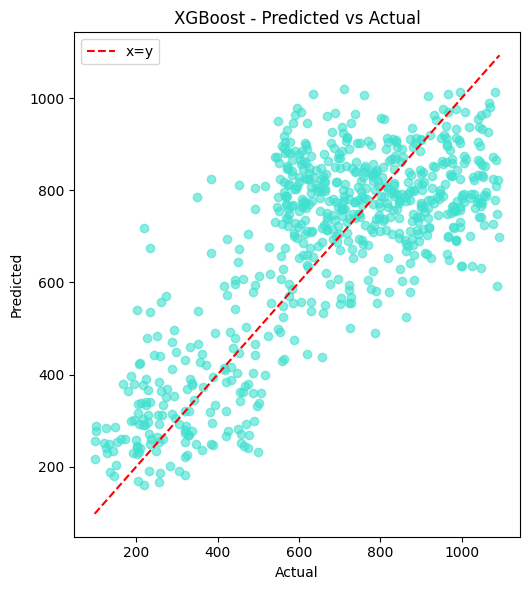

In [23]:

# Predicted vs Actual plot for error analysis
plt.figure(figsize=(10, 6))


# Scatter plot for XGBoost
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_xgb_basic, color='turquoise', alpha=0.6)
plt.title("XGBoost - Predicted vs Actual")
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Add x=y line
line_range = np.linspace(min(y_test.min(), y_pred_xgb_basic.min()), max(y_test.max(), y_pred_xgb_basic.max()), 100)
plt.plot(line_range, line_range, color='red', linestyle='--', linewidth=1.5, label='x=y')
plt.legend()

plt.tight_layout()
plt.show()



This Predicted vs Actual plot is used for error analysis and evaluating model performance.

Each point represents an individual prediction made by the model (y-axis) against the true value (x-axis).

The red dashed line (x=y) represents perfect predictions. Any point on this line indicates that the model predicted the exact value.

Points above the x=y line indicate overestimation by the model (predicted value > actual value).

Points below the x=y line indicate underestimation by the model (predicted value < actual value).


Observations:


Many points are not on the x=y but close to it. We will perfer to make the far points closer than the close ones closer.

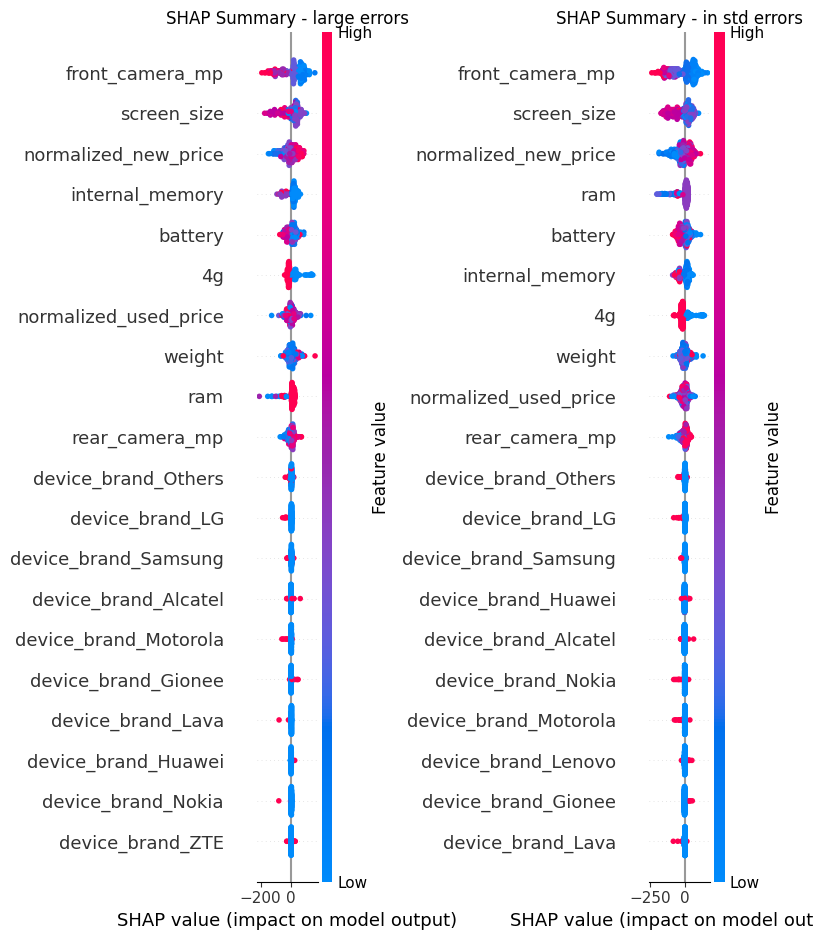

In [24]:

import shap

threshold_xgb = np.std(errors_xgb)
# Divied the test samples into samples with small errors (less than std)
# and large errors.
wrong_prediction = np.abs(errors_xgb) > threshold_xgb
small_error = np.abs(errors_xgb) < threshold_xgb
wrong_prediction_group = X_test[wrong_prediction]
small_error_group = X_test[small_error]

# SHAP for XGBoost, for small errors and large errors.
explainer_xgb = shap.Explainer(xgb_basic, X_test)
shap_values_xgb_wrong_prediction = explainer_xgb(wrong_prediction_group)
shap_values_xgb_small_error = explainer_xgb(small_error_group)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# SHAP Summary Plot for large errors
plt.sca(axes[0])
shap.summary_plot(shap_values_xgb_wrong_prediction, wrong_prediction_group, plot_type="dot", show=False)
axes[0].set_title("SHAP Summary - large errors")

# SHAP Summary Plot for small errors
plt.sca(axes[1])
shap.summary_plot(shap_values_xgb_small_error, small_error_group, plot_type="dot", show=False)
axes[1].set_title("SHAP Summary - in std errors")

# Adjust layout and display
plt.tight_layout()
plt.show()




SHAP is a method for interpreting machine learning models by assigning each feature a contribution to the model's prediction. SHAP provides insights into which features are most important and how they affect the model's output.

We computed SHAP values on 2 groups - samples with large errors and those within the standard deviation.

By comparing the SHAP values for these groups, we can understand how features influence the predictions differently for each set.


In our error analysis, we identified two distinct groups: samples with large errors and those with small errors. Our primary objective was to minimize the large errors, as these have a greater impact on the model's overall performance. By addressing these significant deviations, we aimed to refine the model's ability to capture complex patterns and produce more reliable predictions, especially in critical or challenging scenarios.


In [25]:
X_test['wrong_prediction'] = wrong_prediction.astype(int)


# Merge X_test and y_test only for correlation calculation
df_for_corr = pd.concat([X_test, y_test.rename('days_used')], axis=1)
# Split into groups using 'wrong_prediction'
group_0 = df_for_corr[df_for_corr['wrong_prediction'] == 0].drop(columns=['wrong_prediction'])
group_1 = df_for_corr[df_for_corr['wrong_prediction'] == 1].drop(columns=['wrong_prediction'])
# Calculate correlation for each group
dtf_corr_0 = group_0.corr(method="pearson").loc[["days_used"]]
dtf_corr_1 = group_1.corr(method="pearson").loc[["days_used"]]


In [26]:
from scipy.stats import pearsonr

# Calculate correlations and p-values

correlations_0 = []
p_values_0 = []
stars_0 = []
for col in group_0.columns:
    if col != "days_used":
        corr, p_val = pearsonr(group_0[col], group_0["days_used"])
        correlations_0.append(corr)
        p_values_0.append(p_val)

        # Add '*' if p-value is less than 0.05
        if p_val < 0.05:
            stars_0.append('*')
        else:
            stars_0.append('')
correlations_1 = []
p_values_1 = []
stars_1 = []
for col in group_1.columns:
    if col != "days_used":
        corr, p_val = pearsonr(group_1[col], group_1["days_used"])
        correlations_1.append(corr)
        p_values_1.append(p_val)

        # Add '*' if p-value is less than 0.05
        if p_val < 0.05:
            stars_1.append('*')
        else:
            stars_1.append('')

<ipython-input-26-7286c3c4833e>:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = pearsonr(group_0[col], group_0["days_used"])
<ipython-input-26-7286c3c4833e>:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = pearsonr(group_1[col], group_1["days_used"])


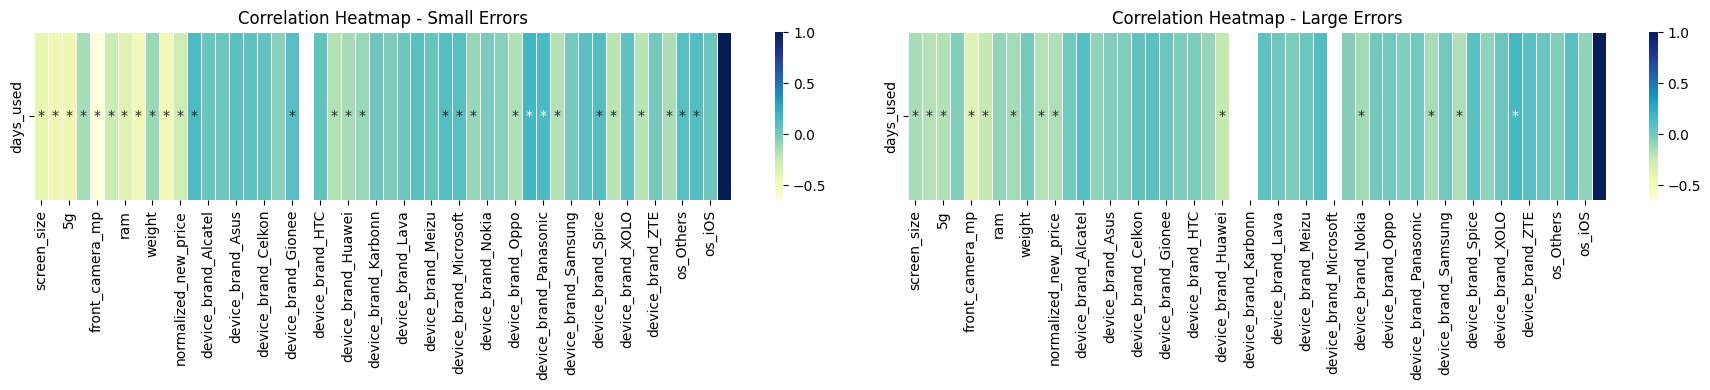

In [27]:


# Create annotation lists for each group
annot_0 = [f'{stars_0[i]}' if i < len(stars_0) else '' for i, _ in enumerate(dtf_corr_0.iloc[0])]
annot_1 = [f'{stars_1[i]}' if i < len(stars_1) else '' for i, _ in enumerate(dtf_corr_1.iloc[0])]

# Plot heatmaps for both groups
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
# Calculate the minimum and maximum values for both correlation matrices
vmin = min(dtf_corr_0.min().min(), dtf_corr_1.min().min())
vmax = max(dtf_corr_0.max().max(), dtf_corr_1.max().max())
# Heatmap for group 0
sns.heatmap(dtf_corr_0, annot=[annot_0], fmt='', cmap="YlGnBu", cbar=True,
            linewidths=0.5, vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title("Correlation Heatmap - Small Errors")

# Heatmap for group 1
sns.heatmap(dtf_corr_1, annot=[annot_1], fmt='', cmap="YlGnBu", cbar=True,
            linewidths=0.5, vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title("Correlation Heatmap - Large Errors")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

The correlation heatmaps illustrate distinct patterns for samples with small errors (left) and those with large errors (right) in the model's predictions. For samples with small errors, the correlations between days_used and features such as front_camera_mp, ram, and 5g are more pronounced, indicating that these variables strongly influence accurate predictions. In contrast, for samples with large errors, these correlations weaken, suggesting that the model struggles to leverage these features effectively in cases of high error. This discrepancy highlights potential challenges in the model's ability to generalize across certain feature combinations or outlier scenarios.

<font color="blue">We see from the different correlations that 4g and 5g have different correlations in the 2 groups.
We thought to make create a new feature by converting 4g and 5g to one feature and removing the unnecessary information that a device has 4g and 5g. (If it has 5g it has 4g).

<font color="blue">4g and 5g features describe the generation of the device. If a device has the 5g feature it is also contained in the 4g group.

##Part 2


Improving the predictive model is essential to enhance its accuracy and applicability. Accurate predictions of device usage duration provide valuable insights for optimizing trade-in programs, pricing strategies, and refurbishment processes, benefiting both businesses and consumers. A better model also supports sustainability by identifying factors that extend device lifespans and reduce waste. Additionally, refining the model minimizes errors, ensures scalability, and makes it more adaptable to diverse datasets and future market needs.

In [28]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

###Creating a new feature "4g_5g"

As we explained above, we merged columns 4g and 5g to get a new feature and then removed them from datasets.
It improved slightly the results.

In [29]:
df_4_and_5 = df_one_hot.copy()
df_4_and_5['4g_5g'] = df_one_hot.apply(lambda row: 'no' if row['4g'] == 0 and row['5g'] == 0
                            else '5g' if row['4g'] == 1 and row['5g'] == 1
                            else '4g' if row['4g'] == 1 and row['5g'] == 0
                            else 'no', axis=1)
df_4_and_5 = df_4_and_5.drop(columns=['4g', '5g'])
df_4_and_5 = pd.get_dummies(df_4_and_5)

In [30]:
X = df_4_and_5.drop(columns=["days_used"])
y = df_4_and_5["days_used"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
xgb_4 = XGBRegressor()
xgb_4.fit(X_train, y_train)
y_pred_xgb_4 = xgb_4.predict(X_test)
mse_xgb_4 = mean_squared_error(y_test, y_pred_xgb_4)
rmse_xgb_4 = np.sqrt(mse_xgb_4)
mae_xgb_4 = mean_absolute_error(y_test, y_pred_xgb_4)
r2_xgb_4 = r2_score(y_test, y_pred_xgb_4)
results.append(["4g", rmse_xgb_4, mae_xgb_4, r2_xgb_4])

# Print the results in a nicely formatted table
print("Model Evaluation Results:")
print(tabulate(results, headers=headers, floatfmt=".4f", tablefmt="pretty"))

Model Evaluation Results:
+---------+--------------------+--------------------+--------------------+
|  Model  |        RMSE        |        MAE         |         R²         |
+---------+--------------------+--------------------+--------------------+
| XGBoost | 167.91102787265046 |  137.502197265625  | 0.558043360710144  |
|   4g    | 166.2677034746977  | 136.18365478515625 | 0.5666517615318298 |
+---------+--------------------+--------------------+--------------------+


###Learnd embeddings for categorial data

Embeddings can be beneficial when dealing with high-cardinality categorical features with complex relationships with the target variable. Based on the correlation analysis, it's likely that embeddings can provide a more compact and meaningful representation of the data, potentially leading to improved model performance compared to one-hot encoding.

Embeddings can help in a few ways-
Reduce the dimensionality of the data.
Capture semantic relationships between categories.
Improve the model's ability to generalize and predict "days_used".

In [31]:
# Assuming df_processed is your dataframe and 'days_used' is the target variable
df_embedding['4g_5g'] = df_embedding.apply(lambda row: 'no' if row['4g'] == 0 and row['5g'] == 0
                            else '5g' if row['4g'] == 1 and row['5g'] == 1
                            else '4g' if row['4g'] == 1 and row['5g'] == 0
                            else 'no', axis=1)
df_embedding = df_embedding.drop(columns=['4g', '5g'])

In [49]:

from sklearn.preprocessing import LabelEncoder


# 1. Split the dataset into features (X) and target (y)
X = df_embedding.drop(columns=["days_used"])
y = df_embedding["days_used"]

# 2. Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing categorical columns
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
label_encoders = {}

# Apply LabelEncoder to each categorical column
for column in categorical_columns:
    le = LabelEncoder()
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])  # Apply the same encoding to X_test
    label_encoders[column] = le  # Save for inverse transformation if needed

# Build the model for embeddings (if needed, based on categorical features)
input_layers = []
embedding_layers = []

# Create input and embedding layers for each categorical feature
embedding_feature_mapping = {}  # Dictionary to map embedding indices to feature names
current_index = 0  # Start index for embeddings
for idx, column in enumerate(categorical_columns):
    num_categories = len(X_train[column].unique())
    embedding_size = min(50, num_categories * 2)  # Choose embedding size

    input_layer = tf.keras.layers.Input(shape=(1,), dtype=tf.int32)
    embedding_layer = tf.keras.layers.Embedding(input_dim=num_categories, output_dim=embedding_size)(input_layer)
    embedding_layer = tf.keras.layers.Flatten()(embedding_layer)

    input_layers.append(input_layer)
    embedding_layers.append(embedding_layer)

    # Map embedding indices to the feature name
    embedding_feature_mapping[column] = list(range(current_index, current_index + embedding_size))
    current_index += embedding_size

# Concatenate embeddings with other non-categorical features
other_features = tf.keras.layers.Input(shape=(X_train.drop(columns=categorical_columns).shape[1],), dtype=tf.float32)
concatenated = tf.keras.layers.concatenate(embedding_layers + [other_features])

# Add a dense layer and output layer
dense_layer = tf.keras.layers.Dense(256, activation='relu')(concatenated)
output_layer = tf.keras.layers.Dense(1)(dense_layer)

# Build the model
model = tf.keras.models.Model(inputs=input_layers + [other_features], outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the categorical columns for the neural network input
X_train_cat = [X_train[column].values for column in categorical_columns]
X_test_cat = [X_test[column].values for column in categorical_columns]

# Ensure the other features are correctly formatted
X_train_non_cat = X_train.drop(columns=categorical_columns).values
X_test_non_cat = X_test.drop(columns=categorical_columns).values

# Train the model
model.fit(X_train_cat + [X_train_non_cat], y_train, epochs=5, batch_size=32)

# Step 2: Extract Embeddings (from the trained model)
embeddings_model = tf.keras.models.Model(inputs=model.input, outputs=concatenated)
train_embeddings = embeddings_model.predict(X_train_cat + [X_train_non_cat])
test_embeddings = embeddings_model.predict(X_test_cat + [X_test_non_cat])

# Step 3: Convert the embeddings to a DataFrame and prepare for XGBoost
embedding_columns = [f"embed_{i}" for i in range(train_embeddings.shape[1])]
X_train_embeddings = pd.DataFrame(train_embeddings, columns=embedding_columns)
X_test_embeddings = pd.DataFrame(test_embeddings, columns=embedding_columns)

# Step 4: Combine embeddings with the rest of the non-categorical features
X_train_final = pd.concat([X_train.drop(columns=categorical_columns).reset_index(drop=True), X_train_embeddings], axis=1)
X_test_final = pd.concat([X_test.drop(columns=categorical_columns).reset_index(drop=True), X_test_embeddings], axis=1)


# Step 6: Train XGBoost on the final data
xgb_cat = XGBRegressor()
xgb_cat.fit(X_train_final, y_train)

# Step 7: Evaluate the model on the test set
y_pred_xgb_cat = xgb_cat.predict(X_test_final)


Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 177427.4688
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160434.1250
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129959.6953
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108704.1484
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84277.5781
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In this process, we integrate categorical feature embeddings into a machine learning pipeline to enhance the predictive power of the model. First, we preprocess the data by encoding categorical columns using LabelEncoder. These encoded features are then passed through embedding layers in a neural network to create dense, low-dimensional representations that capture relationships within the categorical data.

The embeddings are extracted from the trained neural network and combined with the non-categorical features to form a comprehensive dataset. Finally, we use this dataset to train an XGBoost regressor, leveraging the embeddings to improve the model’s ability to predict the target variable, days_used. This approach helps capture complex interactions within categorical features while retaining the power of gradient boosting for tabular data.
The improvement is shown in the table below.

In [59]:
mse_xgb_cat = mean_squared_error(y_test, y_pred_xgb_cat)
rmse_xgb_cat = np.sqrt(mse_xgb_cat)
mae_xgb_cat = mean_absolute_error(y_test, y_pred_xgb_cat)
r2_xgb_cat = r2_score(y_test, y_pred_xgb_cat)
results.append(["Embedding", rmse_xgb_cat, mae_xgb_cat, r2_xgb_cat])

# Print the results in a nicely formatted table
print("Model Evaluation Results:")
print(tabulate(results, headers=headers, floatfmt=".4f", tablefmt="pretty"))

Model Evaluation Results:
+-----------+--------------------+--------------------+--------------------+
|   Model   |        RMSE        |        MAE         |         R²         |
+-----------+--------------------+--------------------+--------------------+
|  XGBoost  | 167.91102787265046 |  137.502197265625  | 0.558043360710144  |
|    4g     | 166.2677034746977  | 136.18365478515625 | 0.5666517615318298 |
| Embedding | 165.52276325705174 | 135.56570434570312 | 0.570526123046875  |
+-----------+--------------------+--------------------+--------------------+


###Attempt to improve model performance through feature selection

In [60]:
from sklearn.feature_selection import VarianceThreshold

# Step 1: Perform variance thresholding (remove features with low variance)
# You can adjust the threshold according to your dataset
variance_threshold = 0.01  # For example, remove features with variance < 0.01
selector = VarianceThreshold(threshold=variance_threshold)

feature_variances = X_train_final.var(axis=0)

# Identify features with variance below the threshold
low_variance_features = feature_variances[feature_variances < variance_threshold]
print("Features with variance below the threshold:")
print(low_variance_features)
X_train_var = selector.fit_transform(X_train_final)
print(X_train_var.shape)
print(X_train_final.shape)
X_test_var = selector.transform(X_test_final)

# Step 2: Train XGBoost with the reduced feature set (after Optuna tuning)
# best_params = study.best_params  # Assuming study is your Optuna study
xgb_final = XGBRegressor()
xgb_final.fit(X_train_var, y_train)

# Step 3: Evaluate the final model on the test set
y_pred_final = xgb_final.predict(X_test_var)
mse_final = mean_squared_error(y_test, y_pred_final)
print(f"Final Mean Squared Error (XGBoost with Optuna after variance-based feature selection): {mse_final}")
rmse_xgb_opt = np.sqrt(mse_final)
print(rmse_xgb_opt)

Features with variance below the threshold:
Series([], dtype: float64)
(2763, 82)
(2763, 82)
Final Mean Squared Error (XGBoost with Optuna after variance-based feature selection): 27397.78515625
165.52276325705174


In [61]:
mae_xgb_n = mean_absolute_error(y_test, y_pred_final)
r2_xgb_n = r2_score(y_test, y_pred_final)
print(mae_xgb_n)
print(r2_xgb_n)

135.56570434570312
0.570526123046875


In [62]:
# Step 1: Compute the correlation of features with the target
correlation = X_train_final.corrwith(y_train)

# Standard filtering: Select features with absolute correlation above 0.001
# when used 0.1 no featires were filtered (all were choosed)
std_threshold = 0.001
selected_features_std = correlation[correlation.abs() > std_threshold].index.tolist()

# Filtering based on the top 90% of correlations
top_90_percent = int(len(correlation) * 0.9)
selected_features_top_90 = correlation.abs().nlargest(top_90_percent).index.tolist()

# Ensure at least one feature is selected in each case
if not selected_features_std:
    raise ValueError("No features were selected with the standard threshold. Adjust the threshold.")
if not selected_features_top_90:
    raise ValueError("No features were selected with the top 90% threshold. Verify the dataset.")

# Debugging: Check dimensions after filtering
print(f"Standard threshold - Selected features: {len(selected_features_std)}")
print(f"Top 90% threshold - Selected features: {len(selected_features_top_90)}")

# Filter the training and test sets based on selected features
X_train_filtered_std = X_train_final[selected_features_std]
X_test_filtered_std = X_test_final[selected_features_std]

X_train_filtered_top_90 = X_train_final[selected_features_top_90]
X_test_filtered_top_90 = X_test_final[selected_features_top_90]

# Debugging: Check filtered DataFrame dimensions
print(f"X_train_filtered_std shape: {X_train_filtered_std.shape}")
print(f"X_train_filtered_top_90 shape: {X_train_filtered_top_90.shape}")

# Ensure filtered DataFrames are not empty
if X_train_filtered_std.empty or X_train_filtered_top_90.empty:
    raise ValueError("Filtered training data is empty. Adjust the correlation threshold or verify the data.")

# Train and evaluate XGBoost models for both scenarios
def train_and_evaluate(X_train, X_test, y_train, y_test, best_params=None):
    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return rmse

# Train and evaluate with default parameters (no Optuna tuning yet)
rmse_std = train_and_evaluate(X_train_filtered_std, X_test_filtered_std, y_train, y_test)
rmse_top_90 = train_and_evaluate(X_train_filtered_top_90, X_test_filtered_top_90, y_train, y_test)

# Print the results
print(f"RMSE with standard threshold (|correlation| > {std_threshold}): {rmse_std}")
print(f"RMSE with top 90% of correlations: {rmse_top_90}")


Standard threshold - Selected features: 80
Top 90% threshold - Selected features: 73
X_train_filtered_std shape: (2763, 80)
X_train_filtered_top_90 shape: (2763, 73)
RMSE with standard threshold (|correlation| > 0.001): 168.02533058664102
RMSE with top 90% of correlations: 172.0802808193751




All features contribute meaningfully to the model, as evidenced by their sufficiently high correlation with the target variable. As a result, removing features based on a predefined correlation threshold did not significantly improve the model's performance. When we lowered the threshold, it had little effect on feature reduction, prompting us to apply a percentage-based selection (e.g., the top 90% of features) to force the removal of more features. However, this approach negatively impacted the model's performance, indicating that the excluded features still held valuable predictive information.

###Optuna

#### optuna installation

In [63]:
!pip install optuna


####Code and explanation


To improve performance, we used Optuna for hyperparameter optimization. Optuna efficiently searches for the best hyperparameter configuration, enhancing model accuracy and robustness while saving time compared to manual tuning. This process helps the model generalize better, capture complex patterns, and deliver reliable predictions.

In [64]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter tuning
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e-1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e-1)
    }

    # Create and train the model
    model = XGBRegressor(**param)
    model.fit(X_train_final, y_train)

    # Predict and calculate MSE
    y_pred = model.predict(X_test_final)
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')  # Minimize MSE
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and MSE
print("Best hyperparameters: ", study.best_params)
print("Best MSE: ", study.best_value)

# Train the final model using the best hyperparameters
best_params = study.best_params
xgb_final = XGBRegressor(**best_params)
xgb_final.fit(X_train_final, y_train)

# Evaluate the final model on the test set
y_pred_final = xgb_final.predict(X_test_final)
mse_final = mean_squared_error(y_test, y_pred_final)
print(f"Final Mean Squared Error (XGBoost with Optuna): {mse_final}")


[I 2025-01-24 13:08:45,252] A new study created in memory with name: no-name-259f6545-17a0-42cb-aa08-15604d341412
<ipython-input-64-76fa9e1b71d3>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
<ipython-input-64-76fa9e1b71d3>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
<ipython-input-64-76fa9e1b71d3>:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 

Best hyperparameters:  {'n_estimators': 900, 'max_depth': 3, 'learning_rate': 0.02249414906675192, 'subsample': 0.9574465315536994, 'colsample_bytree': 0.9698222928268866, 'reg_alpha': 0.003157296122074547, 'reg_lambda': 3.9394257852119284e-05}
Best MSE:  23866.52734375
Final Mean Squared Error (XGBoost with Optuna): 23866.52734375


####Results

In [65]:
mse_xgb_opt = mean_squared_error(y_test, y_pred_final)
rmse_xgb_opt = np.sqrt(mse_xgb_opt)
mae_xgb_opt = mean_absolute_error(y_test, y_pred_final)
r2_xgb_opt = r2_score(y_test, y_pred_final)
results.append(["Optuna", rmse_xgb_opt, mae_xgb_opt, r2_xgb_opt])

# Print the results in a nicely formatted table
print("Model Evaluation Results:")
print(tabulate(results, headers=headers, floatfmt=".4f", tablefmt="pretty"))

Model Evaluation Results:
+-----------+--------------------+--------------------+--------------------+
|   Model   |        RMSE        |        MAE         |         R²         |
+-----------+--------------------+--------------------+--------------------+
|  XGBoost  | 167.91102787265046 |  137.502197265625  | 0.558043360710144  |
|    4g     | 166.2677034746977  | 136.18365478515625 | 0.5666517615318298 |
| Embedding | 165.52276325705174 | 135.56570434570312 | 0.570526123046875  |
|  Optuna   | 154.48795209902292 | 129.54574584960938 | 0.6258803606033325 |
+-----------+--------------------+--------------------+--------------------+


##Final results and conclusions

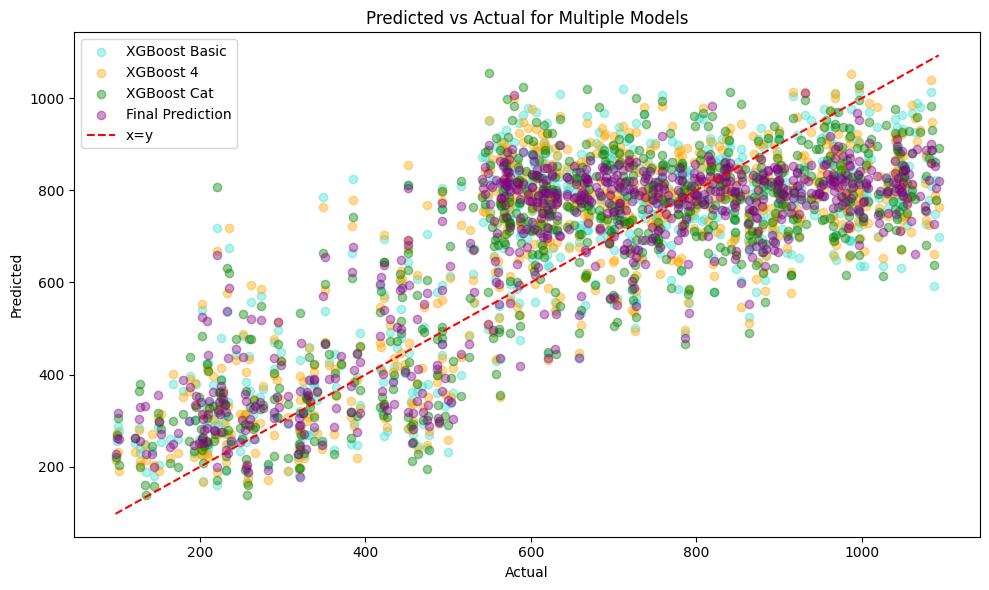

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Define predictions and their labels
predictions = {
    "XGBoost Basic": y_pred_xgb_basic,
    "XGBoost 4": y_pred_xgb_4,
    "XGBoost Cat": y_pred_xgb_cat,
    "Final Prediction": y_pred_final,
}

# Colors for each prediction set
colors = ['turquoise', 'orange', 'green', 'purple']

# Create the plot
plt.figure(figsize=(10, 6))
for (label, y_pred), color in zip(predictions.items(), colors):
    plt.scatter(y_test, y_pred, color=color, alpha=0.4, label=label)

# Add x=y line
line_range = np.linspace(min(y_test.min(), *[pred.min() for pred in predictions.values()]),
                         max(y_test.max(), *[pred.max() for pred in predictions.values()]), 100)
plt.plot(line_range, line_range, color='red', linestyle='--', linewidth=1.5, label='x=y')

# Add labels, legend, and title
plt.title("Predicted vs Actual for Multiple Models")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()




The visualization illustrates what can also be observed in the table, which we have included here for easier comparison: the final results (in purple) are the most accurate. This is evident from their closer distribution around the red line, which represents the true values.

It is important to note that the target we are analyzing is not the intended primary objective. While the correlations with the data are not particularly low, they are also not very high, limiting the potential insights that can be derived. The optimization was performed on the RMSE metric, as our primary focus was on reducing large errors, which are more problematic and impactful.

In [67]:
# Print the results in a nicely formatted table
print("Model Evaluation Results:")
print(tabulate(results, headers=headers, floatfmt=".4f", tablefmt="pretty"))

Model Evaluation Results:
+-----------+--------------------+--------------------+--------------------+
|   Model   |        RMSE        |        MAE         |         R²         |
+-----------+--------------------+--------------------+--------------------+
|  XGBoost  | 167.91102787265046 |  137.502197265625  | 0.558043360710144  |
|    4g     | 166.2677034746977  | 136.18365478515625 | 0.5666517615318298 |
| Embedding | 165.52276325705174 | 135.56570434570312 | 0.570526123046875  |
|  Optuna   | 154.48795209902292 | 129.54574584960938 | 0.6258803606033325 |
+-----------+--------------------+--------------------+--------------------+


In addition to the RMSE that we analyzed and optimized, we can also observe from the table that the MAE has decreased. This reduction in MAE aligns with the decrease in RMSE, further indicating an improvement in model performance.

Additionally, we can observe from the table that the \( R^2 \) value increased with each step, indicating an improvement in the model's performance.



 90%|==================  | 622/691 [00:16<00:01]       

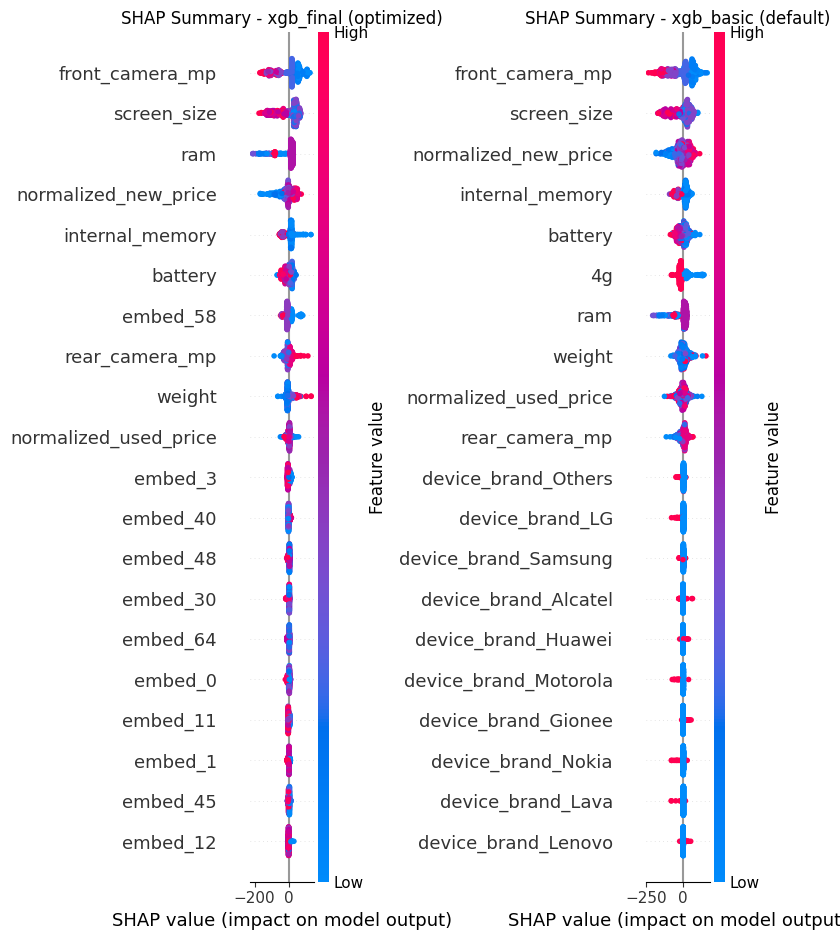

In [68]:
# SHAP for XGBoost models: xgb_final and xgb_basic
explainer_final = shap.Explainer(xgb_final, X_test_final)
shap_values_final = explainer_final(X_test_final)

explainer_basic = shap.Explainer(xgb_basic, X_test_basic)
shap_values_basic = explainer_basic(X_test_basic)

# Plotting SHAP summary plots for the two models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# SHAP Summary Plot for xgb_final
plt.sca(axes[0])
shap.summary_plot(shap_values_final, X_test_final, plot_type="dot", show=False)
axes[0].set_title("SHAP Summary - xgb_final (optimized)")

# SHAP Summary Plot for xgb_basic
plt.sca(axes[1])
shap.summary_plot(shap_values_basic, X_test_basic, plot_type="dot", show=False)
axes[1].set_title("SHAP Summary - xgb_basic (default)")

# Adjust layout and display
plt.tight_layout()
plt.show()


In [73]:
def get_feature_for_index(embedding_feature_mapping, index):
    # Iterate over the embedding_feature_mapping to find the corresponding feature
    for feature, index_range in embedding_feature_mapping.items():
        if index in index_range:
            return feature
    return None


index_to_find = 58
feature = get_feature_for_index(embedding_feature_mapping, index_to_find)
print(f"The feature corresponding to index {index_to_find} (high place in SHAP) is: {feature}")

lower_indecies = [3,40,48,30,64,0,11,1,45,12]
features = set()
for index in lower_indecies:
  feature = get_feature_for_index(embedding_feature_mapping, index)
  if feature is not None:
    features.add(feature)

print(f"The feature corresponding to indeices on the bottom of the SHAP bar are: {features}")

The feature corresponding to index 58 (high place in SHAP) is: 4g_5g
The feature corresponding to indeices on the bottom of the SHAP bar are: {'device_brand'}


From comparing the SHAP results on the basic model from part 1 and the improved model after all improvements we can see that the importance of the features is similar. Fro analyzing the name of the features corresponding to the indeicies we see it matches the right plot - 4g_5g high , and device lower with the devices on the right.

This is a little surprising, but it suggests that despite the improvements made in the model, the relative importance of the features hasn't drastically changed. This could indicate that the features that were already significant in the basic model continue to play an important role in the improved version.

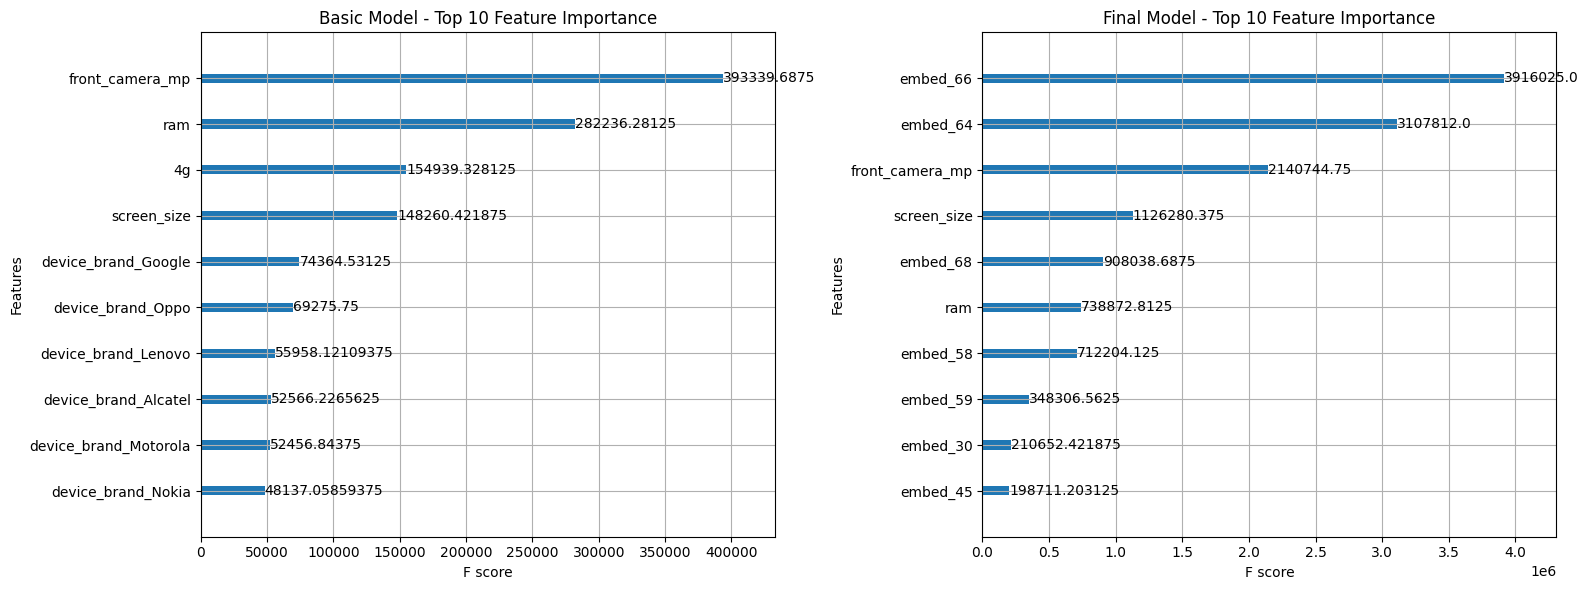

In [74]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Assuming xgb_basic and xgb_final are your trained XGBoost models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot for the basic model (xgb_basic)
plot_importance(xgb_basic, importance_type='gain', max_num_features=10, ax=axes[0])
axes[0].set_title("Basic Model - Top 10 Feature Importance")

# Plot for the final model (xgb_final)
plot_importance(xgb_final, importance_type='gain', max_num_features=10, ax=axes[1])
axes[1].set_title("Final Model - Top 10 Feature Importance")

# Adjust layout and display
plt.tight_layout()
plt.show()


In [81]:
important_indecies = [66,64,58,68,59,30,45]
features = set()
for index in important_indecies:
  feature = get_feature_for_index(embedding_feature_mapping, index)
  if feature is not None:
    features.add(feature)
print(f"The feature corresponding to indeices on the bottom of the SHAP bar are: {features}")

The feature corresponding to indeices on the bottom of the SHAP bar are: {'4g_5g', 'device_brand'}


The top 10 most important features in both the basic and final models are quite similar, but their order differs significantly. This difference in ranking is more pronounced than the variations observed in the SHAP values. This suggests that while the overall feature importance remains largely consistent between the two models, there are subtle differences in how the models prioritize these features.


From the analysis, we observe that in most important features for the model there are device brand, screen size, and price. This is quite intuitive, as factors like the device type, screen size, and the price paid for the device can significantly impact how frequently and for how long the device is used. For instance, a higher-priced device with advanced features and a larger screen might lead to increased usage, while a lower-priced or older device might see less engagement. This aligns with expectations, as consumers often use devices they perceive to be more valuable or functional, thus affecting the overall "days used."

In [91]:
# For basic model
corr_basic = df_basic.corr(method="pearson")["days_used"].drop("days_used")

# For final model
corr_final = df_final.corr(method="pearson")["days_used"].drop("days_used")


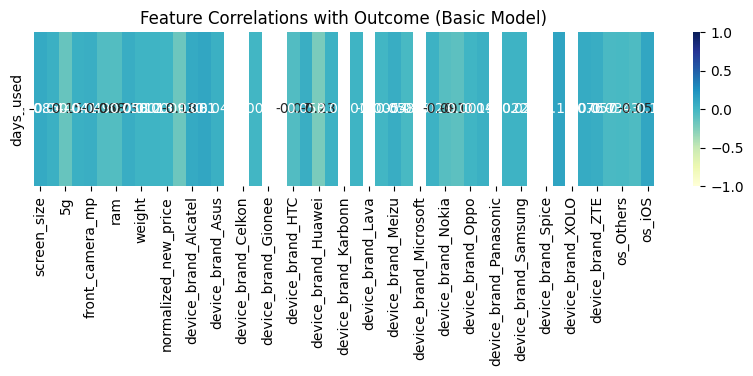

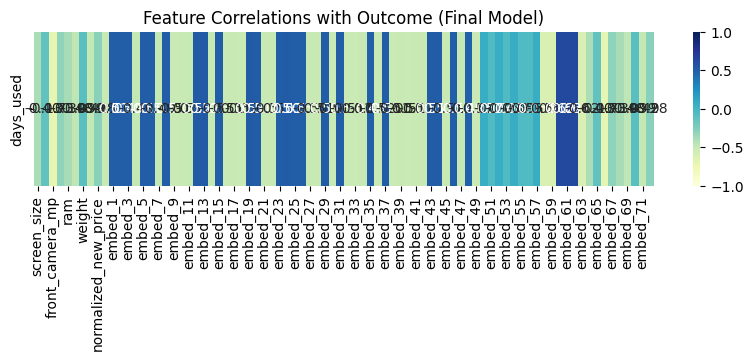

In [94]:


# Create DataFrames for basic and final model correlations
corr_basic_df = corr_basic.to_frame().T  # Transpose for heatmap formatting
corr_final_df = corr_final.to_frame().T  # Transpose for heatmap formatting

# Plot heatmap for basic model
plt.figure(figsize=(10, 2))
sns.heatmap(corr_basic_df, annot=True, cmap="YlGnBu", cbar=True, vmin=-1, vmax=1)
plt.title("Feature Correlations with Outcome (Basic Model)")
plt.show()

# Plot heatmap for final model
plt.figure(figsize=(10, 2))
sns.heatmap(corr_final_df, annot=True, cmap="YlGnBu", cbar=True, vmin=-1, vmax=1)
plt.title("Feature Correlations with Outcome (Final Model)")
plt.show()



The comparison demonstrates that the final model captures more interpretable and realistic relationships between the features and days_used. The patterns suggest that product specifications and brand identity significantly influence device longevity, and the advanced feature engineering in the final model minimizes noise and improves predictive performance. However, the brand-specific biases highlight the need for cautious interpretation, as these may not generalize to different datasets or regions.

In [99]:
# Calculate metrics for the training set
y_train_pred = xgb_final.predict(X_train_final)

mse_xgb_train = mean_squared_error(y_train, y_train_pred)
rmse_xgb_train = np.sqrt(mse_xgb_train)
mae_xgb_train = mean_absolute_error(y_train, y_train_pred)
r2_xgb_train = r2_score(y_train, y_train_pred)

# Append results for training set
results.append(["Train (final model)", rmse_xgb_train, mae_xgb_train, r2_xgb_train])

# Print the results in a nicely formatted table
print("Model Evaluation Results:")
print(tabulate(results, headers=headers, floatfmt=".4f", tablefmt="pretty"))

Model Evaluation Results:
+---------------------+--------------------+--------------------+--------------------+
|        Model        |        RMSE        |        MAE         |         R²         |
+---------------------+--------------------+--------------------+--------------------+
|       XGBoost       | 167.91102787265046 |  137.502197265625  | 0.558043360710144  |
|         4g          | 166.2677034746977  | 136.18365478515625 | 0.5666517615318298 |
|      Embedding      | 165.52276325705174 | 135.56570434570312 | 0.570526123046875  |
|       Optuna        | 154.48795209902292 | 129.54574584960938 | 0.6258803606033325 |
| Train (final model) | 134.6697421588272  | 111.83563232421875 | 0.7038928270339966 |
+---------------------+--------------------+--------------------+--------------------+


As demonstrated in the table, the evaluation metrics reveal a slight degree of overfitting, indicating that the model performs marginally better on the training set compared to the test set. This observation suggests that there is still room for further improvement in the model, either by fine-tuning its hyperparameters, exploring more advanced feature engineering, or employing regularization techniques to enhance its generalization capabilities.

###potential applications for the dataset or findings

This project focuses on analyzing a dataset containing phone and tablet features, with the target variable being days_used. By leveraging advanced machine learning techniques, such as embeddings for categorical features and hyperparameter optimization using Optuna, we improved the model’s ability to predict device lifespan. Embeddings effectively capture intricate patterns in high-dimensional categorical data, enhancing the model's representation power (Guo & Berkhahn, 2016). Simultaneously, Optuna’s efficient hyperparameter tuning framework enabled us to systematically identify the optimal configurations for reducing prediction errors (Akiba et al., 2019).

We employed imputation methods tailored to the nature of the data, using medians for numerical features to ensure robustness against skewed distributions.
Additionally, we utilized SHAP (SHapley Additive exPlanations) to interpret the model’s predictions and gain insights into the importance of various features. SHAP provided a detailed view of how individual features, such as screen_size, battery, and front_camera_mp, contributed to predictions. This not only enhanced our understanding of the model's inner workings but also helped validate its reliability by confirming that critical features aligned with domain knowledge and real-world expectations (Lundberg & Lee, 2017).

The findings have implications for the real world. Device manufacturers can use these insights to design products that better meet customer needs. For example, features like screen_size and battery, which ranked highly in importance, highlight key areas where improving quality can directly enhance user satisfaction and extend device usage. Retailers can also use the model’s predictions to optimize inventory management, focusing on devices with a higher likelihood of prolonged use.

Moreover, marketing teams can create targeted campaigns emphasizing features that users value most, increasing both engagement and sales. For instance, promoting devices with advanced cameras (front_camera_mp) to photography enthusiasts or highlighting battery life for travelers can yield significant benefits. These strategies not only improve profitability but also align products with customer preferences, fostering long-term brand loyalty.

From a sustainability perspective, understanding and improving days_used is critical for reducing e-waste. Extending device lifespans through informed design and marketing strategies can decrease the frequency of replacements, contributing to environmental conservation and aligning with global sustainability goals.

The technical innovations used in this project, including feature embeddings, SHAP analysis, and hyperparameter optimization, demonstrate the power of combining automated feature engineering with interpretability tools to achieve scalable, accurate predictions. By reducing the RMSE and focusing on robust handling of missing data and outliers, we addressed the need to minimize large errors in predicting days_used, ensuring that stakeholders can trust the model’s outputs for critical decision-making.


References:

Guo, C., & Berkhahn, F. (2016). Entity embeddings of categorical variables. arXiv preprint arXiv:1604.06737.

Akiba, T., Sano, S., Yanase, T., Ohta, T., & Koyama, M. (2019). Optuna: A next-generation hyperparameter optimization framework. Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, 2623-2631.

Lundberg, S. M., & Lee, S.-I. (2017). A unified approach to interpreting model predictions. Advances in Neural Information Processing Systems, 30, 4765–4774.

Prokhorenkova, L., Gusev, G., Vorobev, A., Dorogush, A. V., & Gulin, A. (2018). CatBoost: unbiased boosting with categorical features. Advances in Neural Information Processing Systems, 31.